# Preambule

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

In [131]:
with open("functions/physio_def_0.py") as f:
    exec(f.read())

In [3]:
# from sys import path as syspath
# syspath.append("./functions/")

In [4]:
%config Completer.use_jedi = False
# from sys import path as syspath
# from os.path import expanduser
# syspath.append(expanduser("~/Seafile/functions/"))
# from general_functions import autocorr, tally

In [5]:
from physio_def_0 import *
# getApparentFreq, getDimensions, getTimes, rebin, 

In [6]:
from os import listdir

## Parse metadata

In [7]:
import xml.etree.ElementTree as ET

In [87]:
%%time

dataDir = "./data/"
FirstFrames = []
mdf = []
features = []

for filename in listdir(dataDir):
    if not filename.endswith(".nd2"):
        continue

    rdr = bf.ImageReader(dataDir+filename, perform_init=True)
    md = bf.get_omexml_metadata(dataDir+filename)
    xml = bf.OMEXML(md)
    Nimages = xml.get_image_count()
    assert Nimages==1 # I assume nikon always saves one per file
    iImage = 0        # hence this
    im = xml.image(iImage)

    tmp = OrderedDict([("Name",filename)])
    date = getattr(im,"AcquisitionDate")
    if date is not None:
        tmp["AcquisitionDate"] = date
    for dim in "XYTCZ":
        tmp["Size"+dim] = getattr(im.Pixels, "Size"+dim)

    tmp["freq"] = getApparentFreq(iImage,xml)

    tmp.update(getDimensions(iImage,xml))
    mdf += [tmp]
    
    
    image = rdr.read(rescale=False,t=0)
    # nikon pads images on left and right with zeros, hence
    varImage = image.var(axis=(0,1))
    assert varImage[0]==0 and varImage[2]==0 and len(varImage)==3
    image = image.T[1]
    FirstFrames += [image]
    
    features += [OrderedDict()]
    realXML = xml.to_xml()
    with open("tmp.xml","w") as f:
        f.write(realXML)
    tree = ET.ElementTree(file="tmp.xml")
    root = tree.getroot()

    annotations = root[-1]
    
    for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
        keys   = elem.findall(   "{%s}"%omeTag + "Key")
        values = elem.findall(   "{%s}"%omeTag + "Value")
        if len(keys)>1:
            raise AssertionError("found more than one image in %s"%filename)
        k,v = keys[0].text, values[0].text
        if "timestamp" in k: continue
        if "dGraphZoom" in k: continue
        if "dGraphOffset" in k: continue
        features[-1][k] = v

CPU times: user 1min 15s, sys: 5.2 s, total: 1min 20s
Wall time: 1min 1s


In [88]:
mdf = pd.DataFrame(mdf)
try: mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except: pass

In [89]:
features = pd.DataFrame(features,index=mdf.Name)

In [90]:
mdf["LineScan"] = ["LineScan" in repr(el) for _,el in features["ID"].items()]

In [91]:
# features[[c for c in features.columns if "average" in c.lower() or "line" in c.lower()]]

In [92]:
mdf.sort_values("freq",ascending=False)

,Name,SizeX,SizeY,SizeT,SizeC,SizeZ,freq,X,[X],Y,[Y],Z,[Z],LineScan
7,256x32_image_slice3_0la_10Ca.nd2,256,32,42436,1,1,438.967555,0.830163,µm,0.830163,µm,None,None,False
3,256x32_image_slice3_0la_2Ca.nd2,256,32,25604,1,1,438.585296,0.830163,µm,0.830163,µm,None,None,False
0,256x32_image_slice3_0la_2Ca001.nd2,256,32,21323,1,1,438.501530,0.830163,µm,0.830163,µm,None,None,False
2,8glc slice 7 256 64 0 016.nd2,256,64,61736,1,1,192.953634,2.485922,µm,2.485922,µm,None,None,False
8,Ca2uM_line_avg0017.nd2,512,512,3063,1,1,30.879905,0.207541,µm,0.207541,µm,None,None,True
1,ryd1uM_line_avg0012.nd2,512,512,2102,1,1,30.868393,0.207541,µm,0.207541,µm,None,None,True
4,8Ca04uM_line__avg0021.nd2,512,512,2136,1,1,30.868267,0.207541,µm,0.207541,µm,None,None,True
5,6Ca2uM_line__avg0029.nd2,512,512,2542,1,1,30.860470,0.207541,µm,0.207541,µm,None,None,True
9,ryd100nM_line_avg0005.nd2,512,512,2402,1,1,30.855620,0.311311,µm,0.311311,µm,None,None,True
6,Ca2uM_line_avg0016.nd2,512,512,867,1,1,30.777397,0.155656,µm,0.155656,µm,None,None,True


# Example of NOT line scan

In [93]:
idx = 2#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
filename = Name.split("(")[0].strip()
print (filename)

8glc  slice 7 256 64 0 016.nd2


In [94]:
rdr = bf.ImageReader(dataDir+filename, perform_init=True)
dimensions = OrderedDict([(coord,mdf.loc[idx,"Size"+coord]) for coord in "XYZCT"])

md = bf.get_omexml_metadata(dataDir+filename)
xml = bf.OMEXML(md)

In [95]:
%%time
image = []
for t in range(dimensions["T"]):
    image += [rdr.read(rescale=False,t=t).T[1]]

image = np.stack(image)

CPU times: user 4min 56s, sys: 26.5 s, total: 5min 23s
Wall time: 5min 49s


In [96]:
times = getTimes(0,xml)
dt = np.diff(times).mean()
lineScaneMode = mdf.loc[idx,"LineScan"]
if lineScaneMode:
    print ("it is a line scan. I'll stitch them all together")
    LineT = np.vstack(image)
    dt = dt/len(image[0])
    times = np.arange(len(LineT))*dt

frequency = 1./dt

In [97]:
mdf.loc[[idx]]

,Name,SizeX,SizeY,SizeT,SizeC,SizeZ,freq,X,[X],Y,[Y],Z,[Z],LineScan
2,8glc slice 7 256 64 0 016.nd2,256,64,61736,1,1,192.953634,2.485922,µm,2.485922,µm,None,None,False


In [98]:
frequency, times.max()

(225.75402753416589, 319.94733069217205)

In [1]:
%%time
plt.figure(figsize=(15,15))
plt.imshow(image.mean(axis=0).T,
           extent=(
               0,image.shape[1]*mdf.loc[idx,"X"],
               image.shape[2]*mdf.loc[idx,"Y"],0
           ))
plt.xlabel("x [%s]"%mdf.loc[idx,"[X]"])
plt.ylabel("y [%s]"%mdf.loc[idx,"[Y]"])
plt.xticks(np.arange(0,image.shape[1]*mdf.loc[idx,"X"],10));
plt.yticks(np.arange(0,np.ceil(image.shape[2]*mdf.loc[idx,"Y"])+1e-10,5));
""

In [100]:
allProfile = image.mean(axis=(1,2))

Text(0.5, 0, 'time [s]')

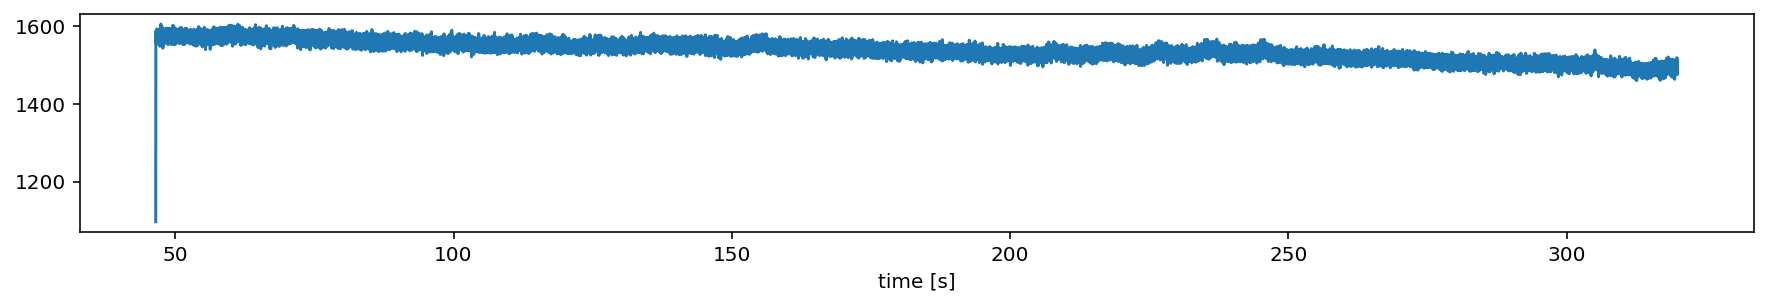

In [101]:
plt.figure(figsize=(15,2))
plt.plot(times,allProfile)
plt.xlabel("time [s]")

In [2]:
showAside = False
fig = plt.figure(figsize=(13,dimensions["Y"]/dimensions["X"]*13*2.5))
if showAside:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]
else:
    axs  = [fig.add_axes([  0,.07,1 ,.4 ]),fig.add_axes([ 0 ,.57, 1,.4 ]),]
    caxs = [fig.add_axes([0.2,.00,.6,.02]),fig.add_axes([0.2,.50,.6,.02]),]

for X,ax,cax,name in zip([image.std(axis=0),image.mean(axis=0)],axs,caxs,["std.dev","mean"]):
    im_ = ax.imshow(X.T, vmin=0)
    plt.colorbar(im_, cax=cax,orientation= "vertical" if showAside else "horizontal")
    ax.set_title(name)

In [103]:
mdf.loc[idx]

Name        8glc  slice 7 256 64 0 016.nd2
SizeX                                  256
SizeY                                   64
SizeT                                61736
SizeC                                    1
SizeZ                                    1
freq                               192.954
X                                  2.48592
[X]                                     µm
Y                                  2.48592
[Y]                                     µm
Z                                     None
[Z]                                   None
LineScan                             False
Name: 2, dtype: object

In [109]:
times.min(), times.max()

(46.485985730532555, 319.94733069217205)

In [118]:
# getTimes(0,xml)

In [ ]:
# features[[c for c in features.columns if "power" in c.lower()]]

In [ ]:
# features[[c for c in features.columns if "offset" in c.lower()]]

In [128]:
multiProfilePlotWithRoi?

In [3]:
multiProfilePlotWithRoi([
#     (150,43),
#     (115,23),
    ( 92,37),
],5,
timeWindow=(100,120),
timeAverageWindow=10,
times_=times-times[0],
image_=image,
stdDev = True
)

In [7]:
t,x = plotTimeProfileForROI(
    pxShow=(92,37),
    pxWin=10,
    timeAverageWindow=4,
    timeWindow=(100,120),
    times_=times-times[0],
    image_=image,
   )

In [5]:
# pxWin=1
# pxShows = [(128+i*(2*pxWin+1),29-j*(2*pxWin+1)) for i in range(4) for j in range(8)]
# print(pxShows)

# multiProfilePlotWithRoi(pxShows=pxShows,
#     pxWin=pxWin,
#     timeWindow=(15,22),
#     timeAverageWindow=10,
#     times_=times-times[0],
#     image_=image,
#     stdDev = True
#     )

In [6]:
t,x = plotTimeProfileForROI((133,25),3,
                            timeAverageWindow=1,
                            timeWindow=(13,16),
                            times_=times-times[0],
                            image_=image,
                            stdDev = True
                           )

plt.figure(figsize=(10,3))
ax = plt.subplot(111)
x = x - np.percentile(x,1)
x = x/x.std()/2
Fit(t,x,ax=ax)
# PS = manyFit(t,x,toll=0)
# ax.plot(t,x)
# ax.plot(t,multiFun(t,PS))

# Example of line scan

In [19]:
mdf

,Name,SizeX,SizeY,SizeT,SizeC,SizeZ,freq,X,[X],Y,[Y],Z,[Z],LineScan
0,256x32_image_slice3_0la_2Ca001.nd2,256,32,21323,1,1,438.501530,0.830163,µm,0.830163,µm,None,None,False
1,ryd1uM_line_avg0012.nd2,512,512,2102,1,1,30.868393,0.207541,µm,0.207541,µm,None,None,True
2,256x32_image_slice3_0la_2Ca.nd2,256,32,25604,1,1,438.585296,0.830163,µm,0.830163,µm,None,None,False
3,8Ca04uM_line__avg0021.nd2,512,512,2136,1,1,30.868267,0.207541,µm,0.207541,µm,None,None,True
4,6Ca2uM_line__avg0029.nd2,512,512,2542,1,1,30.860470,0.207541,µm,0.207541,µm,None,None,True
5,Ca2uM_line_avg0016.nd2,512,512,867,1,1,30.777397,0.155656,µm,0.155656,µm,None,None,True
6,256x32_image_slice3_0la_10Ca.nd2,256,32,42436,1,1,438.967555,0.830163,µm,0.830163,µm,None,None,False
7,Ca2uM_line_avg0017.nd2,512,512,3063,1,1,30.879905,0.207541,µm,0.207541,µm,None,None,True
8,ryd100nM_line_avg0005.nd2,512,512,2402,1,1,30.855620,0.311311,µm,0.311311,µm,None,None,True
9,Ca2uM_line_avg0015.nd2,512,512,399,1,1,30.690881,0.155656,µm,0.155656,µm,None,None,True


In [53]:
idx = 1 # np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
print (Name)
filename = Name#.split("(")[0].strip()
rdr = bf.ImageReader(dataDir+filename, perform_init=True)
dimensions = OrderedDict([(coord,mdf.loc[idx,"Size"+coord]) for coord in "XYZCT"])

md = bf.get_omexml_metadata(dataDir+filename)
xml = bf.OMEXML(md)

ryd1uM_line_avg0012.nd2


In [54]:
%%time
image = []
for t in range(dimensions["T"]):
    image += [rdr.read(rescale=False,t=t)[:,:,1]]

image = np.stack(image)

CPU times: user 20.1 s, sys: 4.49 s, total: 24.6 s
Wall time: 29.4 s


In [55]:
times = getTimes(0,xml)
dt = np.diff(times).mean()
lineScaneMode = mdf.loc[idx,"LineScan"]
if lineScaneMode:
    print ("it is a line scan. I'll stitch them all together into an object called LineT")
    LineT = np.vstack(image)
    dt = dt/len(image[0])
    times = np.arange(len(LineT))*dt

frequency = 1./dt

it is a line scan. I'll stitch them all together into an object called LineT


In [56]:
mdf.loc[[idx]]

,Name,SizeX,SizeY,SizeT,SizeC,SizeZ,freq,X,[X],Y,[Y],Z,[Z],LineScan
1,ryd1uM_line_avg0012.nd2,512,512,2102,1,1,30.868393,0.207541,µm,0.207541,µm,None,None,True


In [57]:
frequency, times

(15825.904768263903,
 array([0.00000000e+00, 6.31875406e-05, 1.26375081e-04, ...,
        6.80037581e+01, 6.80038213e+01, 6.80038845e+01]))

In [58]:
times.min(),times.max()

(0.0, 68.00388450195769)

In [85]:
smoothAvgLine = rebin(LineT,100,axis=0)
offsets = np.percentile(smoothAvgLine,1,axis=0)
offsetM = np.array([offsets]*len(smoothAvgLine))
smoothAvgLine = smoothAvgLine - offsetM

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(smoothAvgLine)#,extent=(0,LineT.shape[1]*mdf.loc[idx,"X"],times.min(),times.max(),))
plt.xlabel("x [%s]"%mdf.loc[idx,"[X]"])
plt.ylabel("time [s]")
plt.gca().set_aspect("auto")

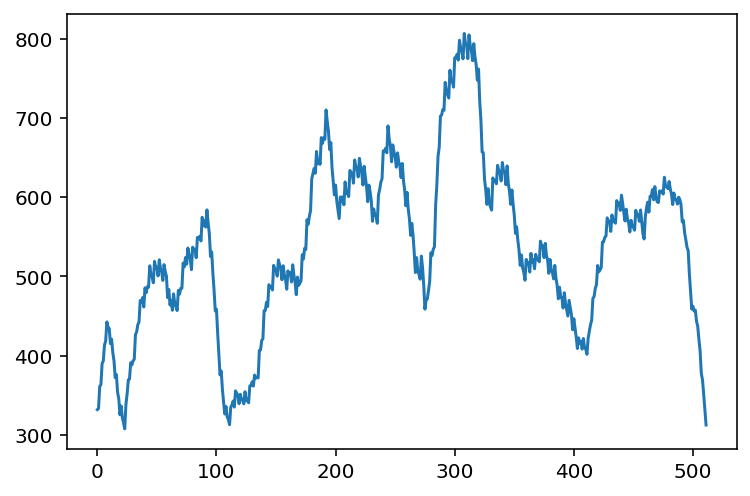

In [62]:
plt.plot(LineT.std(axis=0))

In [67]:
avgWindow = 30
iShow = 50
pxAvg = 3

# dt = 40
# t0s = np.arange(0,times.max(),dt)[:-1]
# fig, axs = plt.subplots(len(t0s),1,figsize=(14,1*len(t0s)), sharey=True)
# for t0,ax in zip(t0s,axs):
#     timeWindow = np.array([t0,t0+dt])
#     twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
#     smoothTime = rebin(times[twIndices],avgWindow)
#     smoothLine = rebin(LineT[twIndices],avgWindow,axis=0)
#     # offsets = np.percentile(smoothLine,5,axis=0)
#     # offsetM = np.array([offsets]*len(smoothLine))
#     # X = smoothLine - offsetM
#     ax.plot(smoothTime,smoothLine.T[iShow-pxAvg:iShow+pxAvg+1].mean(axis=0))
#     if t0<t0s[-1]:
#         ax.set_xticks([])
# fig.tight_layout(h_pad=0)

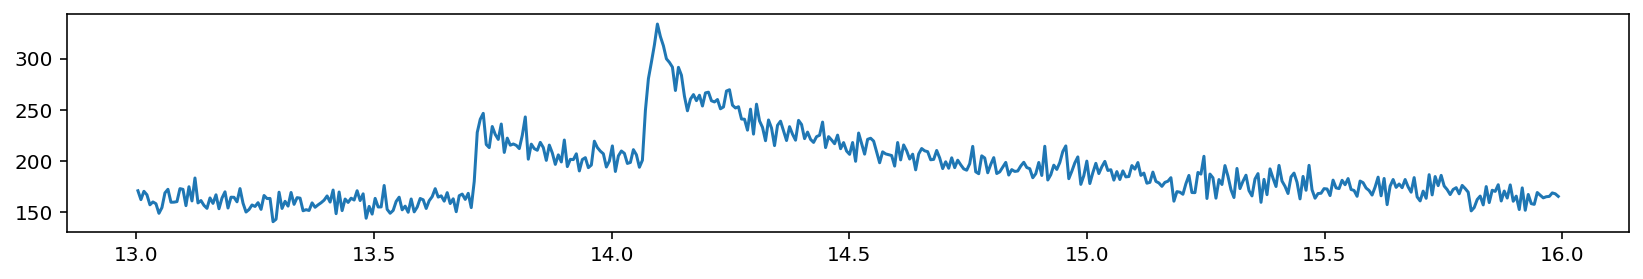

In [76]:
iShow = 50
pxAvg = 20
avgWindow = 100
fig = plt.figure(figsize=(14,2))
ax = plt.subplot(111)
# timeWindow = np.array([0,times.max()])
timeWindow = np.array([13,16])
twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
smoothTime = rebin(times[twIndices],avgWindow)
smoothLine = rebin(LineT[twIndices],avgWindow,axis=0)
# offsets = np.percentile(smoothLine,5,axis=0)
# offsetM = np.array([offsets]*len(smoothLine))
# X = smoothLine - offsetM
ax.plot(smoothTime,smoothLine.T[iShow-pxAvg:iShow+pxAvg+1].mean(axis=0))

In [80]:
smoothAvgLine.shape

(107622, 512)

In [82]:
# map(np.argmax,smoothAvgLine.nmax(axis=0)

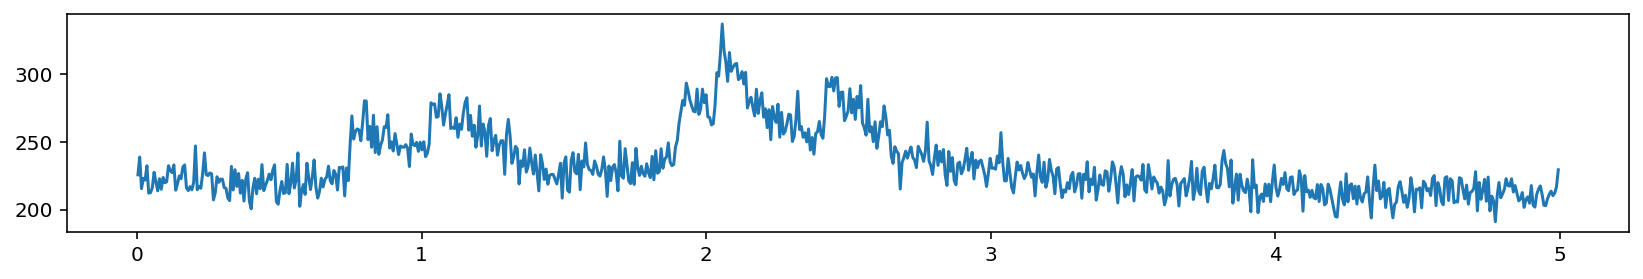

In [83]:
iShow = 196
pxAvg = 30
avgWindow = 100
fig = plt.figure(figsize=(14,2))
ax = plt.subplot(111)
# timeWindow = np.array([0,times.max()])
timeWindow = np.array([0,5])
twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
smoothTime = rebin(times[twIndices],avgWindow)
smoothLine = rebin(LineT[twIndices],avgWindow,axis=0)
# offsets = np.percentile(smoothLine,5,axis=0)
# offsetM = np.array([offsets]*len(smoothLine))
# X = smoothLine - offsetM
ax.plot(smoothTime,smoothLine.T[iShow-pxAvg:iShow+pxAvg+1].mean(axis=0))

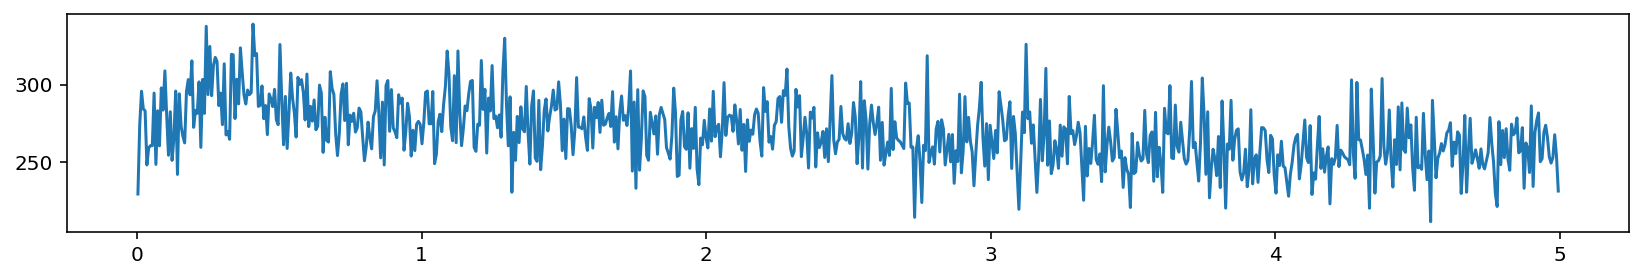

In [84]:
iShow = 325
pxAvg = 10
avgWindow = 100
fig = plt.figure(figsize=(14,2))
ax = plt.subplot(111)
# timeWindow = np.array([0,times.max()])
timeWindow = np.array([0,5])
twIndices = slice(*(np.where(times>=tl)[0][0] for tl in timeWindow))
smoothTime = rebin(times[twIndices],avgWindow)
smoothLine = rebin(LineT[twIndices],avgWindow,axis=0)
# offsets = np.percentile(smoothLine,5,axis=0)
# offsetM = np.array([offsets]*len(smoothLine))
# X = smoothLine - offsetM
ax.plot(smoothTime,smoothLine.T[iShow-pxAvg:iShow+pxAvg+1].mean(axis=0))

# Kill javabridge

In [ ]:
javabridge.kill_vm()